In [ ]:
%load_ext tensorboard

from dataclasses import asdict, dataclass
from IPython.display import display, Markdown as md
import itertools
import matplotlib.pyplot as plt
import numpy as np

from scipy.integrate import odeint

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.nn.init import xavier_uniform_
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm
from typing import Optional

In [ ]:
@dataclass
class Hyperparams():
    """Keeps track of training/model hyperparameters."""
    lr: Optional[float] = None
    n_epochs: Optional[int] = None
    L1_lambda: Optional[float] = None
    train_size: Optional[int] = None
    batch_size: Optional[int] = None
    n_layers: Optional[int] = None
    hidden_size: Optional[int] = None
    input_size: Optional[int] = None
    latent_size: Optional[int] = None
    print_interval: Optional[int] = None
    n_layers: Optional[int] = None
    terms: Optional[list] = None
    bias: Optional[bool] = None
    thresholding: Optional[str] = None
    interval_s: Optional[int] = None
    s_a: Optional[float] = None
    p_a: Optional[float] = None
    p_b: Optional[float] = None
    interval_p: Optional[int] = None

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Exercise 6

## 1 SINDy in Ground Truth Coordinates z

### 1.1 Simulation

In [ ]:
def pendulum_rhs(zt:list, dzt:list, coefficients:list, terms:list) -> list:
    """
    Compute the scalar product between the coefficients and the function terms.

    The scalar product is computed for all given points (zt, dzt).
    """
    scalar_products = []

    for i in range(len(zt)):
        sum = 0
        for j in range(len(coefficients)):
            sum += coefficients[j] * terms[j](zt[i], dzt[i])
        scalar_products.append(sum)

    return scalar_products


def pendulum_ode_step(y: list, t: list, coefficients: list, terms: list) -> list:
    """
    First order ODE representation of the pendulum.

    Since the motion of the pendulum is described by a 2nd
    order ODE and 'scipy.integrat.ode' solves only 1st order
    ODE systems, we transform the 2nd order ODE to a
    1st order ODE.
    """
    theta, omega = y
    dydt = [omega] + pendulum_rhs([theta], [omega], coefficients, terms)
    return dydt



def simulate_pendulum(z0, dz0, coefficients, terms, T, dt):
    """Simulate pendulum movement for T steps with step size dt."""
    y0 = [z0, dz0]
    t = np.arange(0, T *  dt, dt)
    return odeint(pendulum_ode_step, y0, t, args=(coefficients, terms))


def create_pendulum_data(
    z0_min,
    z0_max,
    dz0_min,
    dz0_max,
    coefficients,
    terms,
    T,
    dt,
    N,
    embedding=None,
    rejection=True,
) -> list:
    """
    Create a set of N simulations with T steps.

    A simulation step t consists of (z(t), dz(t), dz(t)).
    The initial conditions are randomly sampled from uniform distributions.
    """
    simulations = []

    for i in range(N):
        z0 = np.random.uniform(z0_min, z0_max, 1)[0]
        dz0 = np.random.uniform(dz0_min, dz0_max, 1)[0]

        if rejection:
            while np.abs(dz0 * dz0 / 2 - np.cos(z0)) > 0.99:
                # Resample initial conditions if the pendulum has
                # too much angular momentum
                z0 = np.random.uniform(z0_min, z0_max, 1)[0]
                dz0 = np.random.uniform(dz0_min, dz0_max, 1)[0]

        simulation = simulate_pendulum(
            z0,
            dz0,
            coefficients,
            terms,
            T,
            dt,
        )

        rhs = pendulum_rhs(simulation[:, 0], simulation[:, 1], coefficients, terms)

        # Append RHS to simulation
        simulation = np.append(simulation, np.array(rhs)[..., None], axis=1)

        simulations.append(simulation)
    return simulations

In [ ]:
# Recommended paramaters
N = 100
z0_min, z0_max = -np.pi, np.pi
dz0_min, dz0_max = -2.1, 2.1
T = 500  # Note: 50 doesn't result in any discernible behaviour
dt = 0.02

# Ground truth 2nd order ODE
terms = [lambda zt, dzt: np.sin(zt)]
coefficients = [-1]

In [ ]:
# Simulate data: Construct canonical training set
simulations = create_pendulum_data(
    z0_min,
    z0_max,
    dz0_min,
    dz0_max,
    coefficients,
    terms,
    T,
    dt,
    N,
)

We now visualize five random simulations of the pendulum $z(t)$ and its two derivates $\dot{z}(t), \ddot{z}(t)$ using the ground truth `coefficients` $(-1)$ and `terms` $(sin(z(t)))$ and the recommended limits of the uniform distributions for the initial conditions. Since simulating only for $T = 50$ with $dt = 0.02$ does not result in any discernible behaviour (The curves of the waves are not visible), we simulate for $T = 500$.

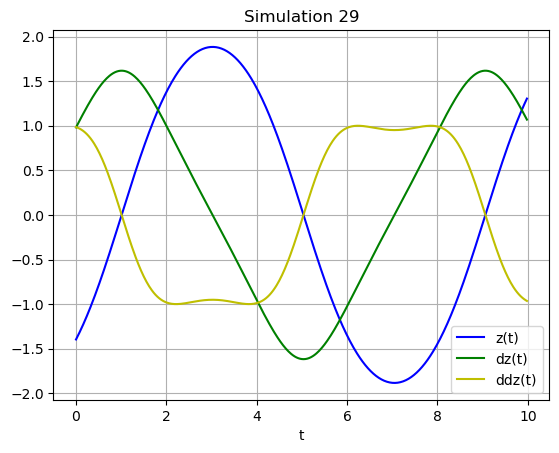

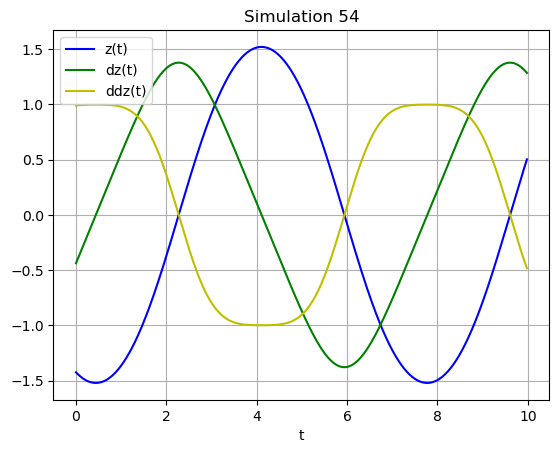

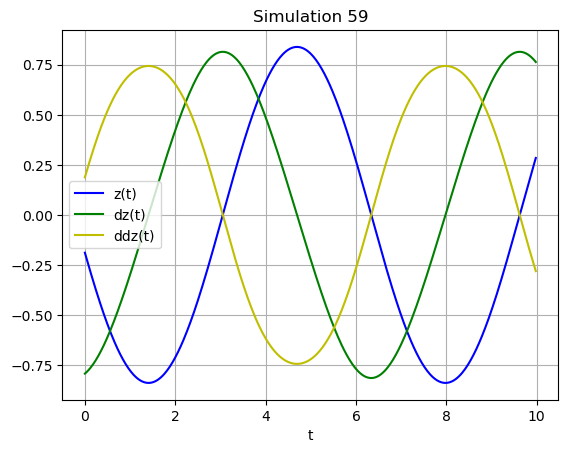

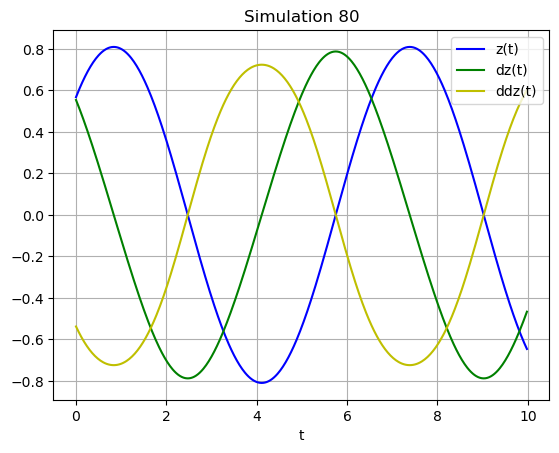

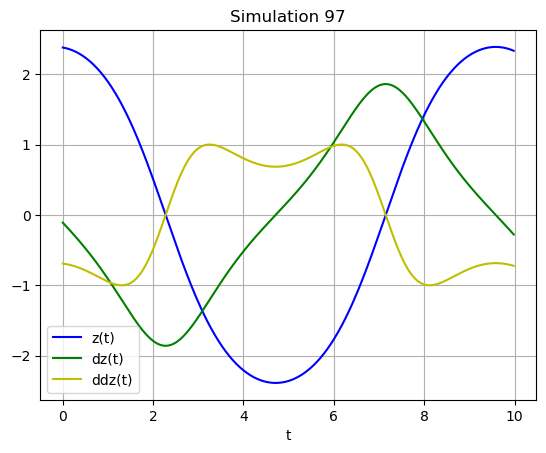

In [ ]:
# Visualize 5 random runs
t = np.arange(0, T *  dt, dt)

idx_sims = np.random.randint(0, N, size=5)
idx_sims = np.sort(idx_sims)

for idx_sim in idx_sims:
    simulation = simulations[idx_sim]

    plt.plot(t, simulation[:, 0], 'b', label='z(t)')
    plt.plot(t, simulation[:, 1], 'g', label='dz(t)')
    plt.plot(t, simulation[:, 2], 'y', label='ddz(t)')
    plt.legend(loc='best')
    plt.xlabel('t')
    plt.title(f'Simulation {idx_sim}')
    plt.grid()
    plt.show()

<div style="color: green; font-weight: bold">Comment:</div> implementation is correct and as good as sample solution.

### 1.2 Implementation & Training

We now implement the two solvers for the SINDy algorithm

In [ ]:
prior_knowledge_terms = [
    lambda zt, dzt: 1,
    lambda zt, dzt: zt,
    lambda zt, dzt: dzt,
    lambda zt, dzt: np.sin(zt),
    lambda zt, dzt: zt * zt,
    lambda zt, dzt: zt * dzt,
    lambda zt, dzt: zt * np.sin(zt),
    lambda zt, dzt: dzt * dzt,
    lambda zt, dzt: dzt * np.sin(zt),
    lambda zt, dzt: np.sin(zt) * np.sin(zt),
]

Below, we compute $\hat{\Xi}$ using **Lasso**, where we don't fit an intercept since the features already include a column of 1's.

In [ ]:
reshaped_simulations = np.array(simulations).reshape((N * T, 3))

In [ ]:
# First solver implementation using Lasso
L1_regularization_lasso = 0.01
reg_lasso = linear_model.Lasso(alpha=L1_regularization_lasso, fit_intercept=False)

data_lasso = reshaped_simulations
y_lasso = data_lasso[:, 2]

initial_features_lasso = data_lasso[:, :2]
# Compute regression features
X_lasso = []
for i in range(initial_features_lasso.shape[0]):
    features = []
    for f in prior_knowledge_terms:
        features.append(f(initial_features_lasso[i][0], initial_features_lasso[i][1]))
    X_lasso.append(features)
X_lasso = np.array(X_lasso)

reg_lasso.fit(X=X_lasso, y=y_lasso)

# Get regression coefficients
xi_lasso = reg_lasso.coef_

In [ ]:
display(md(f'Lasso coefficients {xi_lasso}'))

Lasso coefficients [-0.         -0.02106553 -0.         -0.94745798 -0.         -0.
 -0.         -0.         -0.         -0.        ]

**<ins>Results (Lasso):</ins>** In out experiments we observed that the L1-regularization weight `L1_regularization_lasso` has a big impact on the resulting regression coefficients. For example, a weight of 0.1 (i.e., a tenfold increase) results in a $sin(z(t))$ coefficient of $\approx -0.4$.

Below, we compute $\hat{\Xi}$ using the **ADAM** optimizer.

<div style="color: green; font-weight: bold">Comment:</div> Good result and observation regarding the impact of l1-regularisation weight.

In [ ]:
# Second solver implementation using ADAM
class SINDy(nn.Module):
    """Model SINDy optimization problem."""
    def __init__(self, **kargs):
        super().__init__()

        self.terms = kargs.get('terms')
        self.n_coeffs = len(self.terms)

        self.linear = nn.Linear(in_features=self.n_coeffs, out_features=1, bias=False)
        # Initialize layer coefficients with ones
        self.linear.weight = torch.nn.Parameter(torch.ones(self.n_coeffs))

        # Initialize mask with ones - all coefficients are active at the beginning
        self.weight_mask = torch.ones(1, self.n_coeffs, dtype=torch.float).to(device)

        # Initialize array for weight history with current weights
        self.weights = [self.linear.weight.detach().clone()]

    def apply_mask(self):
        model.linear.weight = torch.nn.Parameter(self.linear.weight.detach().clone() * self.weight_mask)

    def forward(self, z, dz):
        # Construct features by applying the function terms
        features = torch.squeeze(
            torch.stack(
                [
                    f(z, dz).to(device)
                    for f in self.terms
                ],
                dim=1,
            )
        ).to(device)
        return self.linear(features).unsqueeze(1)

<div style="color: green; font-weight: bold">Comment:</div> Conceptually, the implementation is correct :). Although I would say the sample solution's implementation of pytorch-LASSO is more elegant.

In [ ]:
def train_sindy(
    model: SINDy,
    train_loader: DataLoader,
    val_loader: DataLoader,
    train_hyperparams: Hyperparams,
):
    """Train SINDy."""
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=train_hyperparams.lr)

    # Load model to device
    model = model.to(device)

    # Initialize arrays for holding epochs
    if train_hyperparams.thresholding == 'patient':
        E_a = torch.ones(size=model.linear.weight.shape, dtype=torch.int)
        E_b = torch.ones(size=model.linear.weight.shape, dtype=torch.int)

    losses = []
    for epoch in range(train_hyperparams.n_epochs):
        mean_batch_loss = 0
        for inputs, target in train_loader:
            model.train()

            # Load data to device
            inputs = inputs.to(device)
            target = target.to(device)

            # Forward pass
            output = model(inputs[:, 0], inputs[:, 1])

            # L1 regularization term
            L1_loss = torch.norm(model.linear.weight, p=1)

            # Construct loss
            loss = criterion(output, target.unsqueeze(1)) + train_hyperparams.L1_lambda * L1_loss

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            mean_batch_loss += loss.item()
        losses.append(mean_batch_loss / len(train_loader))

        if train_hyperparams.thresholding == 'sequential':
            if epoch % train_hyperparams.interval_s == 0:
                # Get current weights
                W = model.linear.weight.detach().clone()

                # Update weight mask
                model.weight_mask = (W.abs() > train_hyperparams.s_a).type(torch.float32)

                # Update/Turn off model weights
                model.linear.weight = torch.nn.Parameter(W * model.weight_mask)

                # Register hook to keep frozen/tunrned off weights from being updated
                model.linear.weight.register_hook(lambda grad: grad.mul_(model.weight_mask))

                # Reregister parameters with the optimizer
                optimizer = optim.Adam(model.parameters(), lr=train_hyperparams.lr)
        if train_hyperparams.thresholding == 'patient':
                # Get current weights
                W = model.linear.weight.detach().clone()

                # Update epoch corresponding to absolute value
                E_a[(W.abs() > train_hyperparams.p_a).type(torch.bool)] = epoch

                # Update epoch corresponding to absolute consecutive delta
                E_b[((W - model.weights[-1]).abs() > train_hyperparams.p_b).type(torch.bool)] = epoch

                if epoch > train_hyperparams.interval_p:
                    # Update mask
                    model.weight_mask = torch.logical_and(
                        model.weight_mask,
                        torch.logical_or(
                            E_a > epoch - train_hyperparams.interval_p,
                            E_b > epoch - train_hyperparams.interval_p,
                        ),
                    ).squeeze()

                    # Update/Turn off model weights
                    model.linear.weight = torch.nn.Parameter(W * model.weight_mask)

                    # Register hook to keep frozen/tunrned off weights from being updated
                    model.linear.weight.register_hook(lambda grad: grad.mul_(model.weight_mask))

                    # Reregister parameters with the optimizer
                    optimizer = optim.Adam(model.parameters(), lr=train_hyperparams.lr)

                # Add current/modified weights to history
                model.weights.append(model.linear.weight.detach().clone())

        model.eval()
        with torch.no_grad():
            val_loss = 0
            for inputs, target in val_loader:
                # Load data to device
                inputs = inputs.to(device)
                target = target.to(device)

                # Forward pass
                output = model(inputs[:, 0], inputs[:, 1])

                loss = criterion(output, target.unsqueeze(1))
                val_loss += loss.item()

        val_loss /= len(val_loader)

        if (epoch + 1) % train_hyperparams.print_interval == 0 or (epoch + 1) == train_hyperparams.n_epochs:
            print(f'Epoch {epoch+1}/{train_hyperparams.n_epochs}, Training Loss: {losses[-1]:.4f}, Val Loss: {val_loss}')
            print(f"Model Coefficients: {model.linear.weight.cpu()}")

<div style="color: green; font-weight: bold">Comment:</div> The `train_sindy`  function is implemented really well and conceptually similar to sample solution's. Although from implementation POV, the sample solution is clearly more elegant, you implementation is also really simple and cool:).

In [ ]:
prior_knowledge_terms_torch = [
    lambda zt, dzt: torch.ones(zt.shape),
    lambda zt, dzt: zt,
    lambda zt, dzt: dzt,
    lambda zt, dzt: torch.sin(zt),
    lambda zt, dzt: zt * zt,
    lambda zt, dzt: zt * dzt,
    lambda zt, dzt: zt * torch.sin(zt),
    lambda zt, dzt: dzt * dzt,
    lambda zt, dzt: dzt * torch.sin(zt),
    lambda zt, dzt: torch.sin(zt) * torch.sin(zt),
]

In [ ]:
class SimulationDataset(Dataset):
    def __init__(self, simulations):
        self.simulations = simulations

    def __len__(self):
        return len(self.simulations)

    def __getitem__(self, idx):
        # Get the simulation at the given index
        simulation_sample = self.simulations[idx]

        # The features are all but the last element
        features = simulation_sample[:-1]

        # The target is the last element
        target = simulation_sample[-1]

        return torch.tensor(features, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

In [ ]:
# Model and training config
sindy_hyperparams = Hyperparams(
    lr=1e-3,
    n_epochs=100,
    terms=prior_knowledge_terms_torch,
    print_interval=10,
    batch_size=512,
    L1_lambda=1e-5,
    thresholding=None,  # Do not apply thresholding
    interval_s=10,
    s_a=0.02,
    p_a=0.1,
    p_b=0.002,
    interval_p=5,
)

In [ ]:
# Create dataset
simulations_dataset = SimulationDataset(reshaped_simulations)

train_size = int(0.8 * len(simulations_dataset))
test_size = len(simulations_dataset) - train_size

# Train-test split
train_dataset, test_dataset = random_split(simulations_dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=sindy_hyperparams.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=sindy_hyperparams.batch_size, shuffle=True)
print("Dataset created")
print(f"Length of train data: {train_size}, validation data: {test_size}")

Dataset created
Length of train data: 40000, validation data: 10000


We now train a SINDy model thresholding-free.

#### Thresholding-free

In [ ]:
# Initialize model
sindy_model = SINDy(**asdict(sindy_hyperparams))
print("Initiated model")

# Start training
print(f"Training with {sindy_hyperparams.thresholding} threhsolding...")
train_sindy(sindy_model, train_loader, test_loader, sindy_hyperparams)

Initiated model
Training with None threhsolding...
Epoch 10/100, Training Loss: 7.7745, Val Loss: 6.97628161907196
Model Coefficients: Parameter containing:
tensor([0.3678, 0.3284, 0.3831, 0.3235, 0.3684, 0.3793, 0.3681, 0.3689, 0.3758,
        0.3683], requires_grad=True)
Epoch 20/100, Training Loss: 0.5738, Val Loss: 0.4985829770565033
Model Coefficients: Parameter containing:
tensor([ 0.0717, -0.0945,  0.0797, -0.1183,  0.0731,  0.0791,  0.0723,  0.0732,
         0.0729,  0.0723], requires_grad=True)
Epoch 30/100, Training Loss: 0.0516, Val Loss: 0.048293907381594184
Model Coefficients: Parameter containing:
tensor([ 0.0040, -0.2724,  0.0040, -0.3429,  0.0046,  0.0064,  0.0047,  0.0061,
        -0.0010,  0.0050], requires_grad=True)
Epoch 40/100, Training Loss: 0.0299, Val Loss: 0.02920152321457863
Model Coefficients: Parameter containing:
tensor([-9.3337e-04, -2.9133e-01, -1.4202e-03, -4.4419e-01, -1.6473e-03,
         7.3522e-04,  3.9701e-04,  1.2582e-03, -6.5270e-03,  1.0519e-03]

**<ins>Results (Thresholding-free):</ins>** While LASSO was able to push most of the coefficients to 0, thresholding-free training can't. While the $sin$ coefficient is correctly computed ($-0.9...$), the other coefficients are small, but non-zero. Furthemore, the regularization weight doesn't seem to help in zeroing out the other coefficients.

<div style="color: green; font-weight: bold">Comment:</div> Good result. although I am a bit surprised that it took 100 epochs to get this result. I think lesser number of epochs would have sufficed for this task. But still, good job :).

The code is also implemented nicely :).

### 1.3 Thresholding

See `train_sindy`.

### 1.4 Evaluation & Visualization

We now train a SINDy model for each thresholding type (i.e., `sequential` and `patient`).

Instead of plotting the model weights and the (train and validation) losses, we display these during training. Once training finishes, we also display the final weight mask.

#### Sequential thresholding

In [ ]:
# Model and training config
sindy_hyperparams = Hyperparams(
    lr=1e-3,
    n_epochs=100,
    terms=prior_knowledge_terms_torch,
    print_interval=10,
    batch_size=512,
    L1_lambda=1e-5,
    thresholding='sequential',  # Sequential training
    interval_s=10,
    s_a=0.02,
    p_a=0.1,
    p_b=0.002,
    interval_p=5,
)

# Initiate model
sindy_seq_model = SINDy(**asdict(sindy_hyperparams))
print("Initiated model")

# Call training
print(f"Training with {sindy_hyperparams.thresholding} threhsolding...")
train_sindy(sindy_seq_model, train_loader, test_loader, sindy_hyperparams)

Initiated model
Training with sequential threhsolding...
Epoch 10/100, Training Loss: 7.1913, Val Loss: 6.417570090293884
Model Coefficients: Parameter containing:
tensor([0.3494, 0.3144, 0.3620, 0.3083, 0.3511, 0.3573, 0.3498, 0.3502, 0.3554,
        0.3494], requires_grad=True)
Epoch 20/100, Training Loss: 0.1131, Val Loss: 0.09604717902839184
Model Coefficients: Parameter containing:
tensor([ 0.0019, -0.2239,  0.0016, -0.2537,  0.0036,  0.0038,  0.0021,  0.0044,
        -0.0026,  0.0017], requires_grad=True)
Epoch 30/100, Training Loss: 0.0100, Val Loss: 0.008645819802768528
Model Coefficients: Parameter containing:
tensor([ 0.0000, -0.1588, -0.0000, -0.6969,  0.0000,  0.0000,  0.0000,  0.0000,
        -0.0000, -0.0000], requires_grad=True)
Epoch 40/100, Training Loss: 0.0000, Val Loss: 9.0128002483425e-08
Model Coefficients: Parameter containing:
tensor([ 0.0000e+00, -5.2014e-04, -0.0000e+00, -9.9903e-01,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00, -0.0000e+00, -0.0

In [ ]:
print(f"Final weight mask: {sindy_seq_model.weight_mask}")

Final weight mask: tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])


**<ins>Results (Sequential thresholding):</ins>** Sequential thresholding works like a charm, beating LASSO. It is able to correctly find the $-1$ coefficients of $sin$ and zero out all the other coefficient.

<div style="color: green; font-weight: bold">Comment:</div> Good results for Sequential thresholding.

#### Patient (PTAT) thresholding

In [ ]:
# Model and training config
sindy_hyperparams = Hyperparams(
    lr=1e-3,
    n_epochs=100,
    terms=prior_knowledge_terms_torch,
    print_interval=10,
    batch_size=512,
    L1_lambda=1e-5,
    thresholding='patient',  # Patient (PTAT) training
    interval_s=10,
    s_a=0.02,
    p_a=0.1,
    p_b=0.002,
    interval_p=5,
)

# Initiate model
sindy_patient_model = SINDy(**asdict(sindy_hyperparams))
print("Initiated model")

# Call training
print(f"Training with {sindy_hyperparams.thresholding} threhsolding...")
train_sindy(sindy_patient_model, train_loader, test_loader, sindy_hyperparams)

Initiated model
Training with patient threhsolding...
Epoch 10/100, Training Loss: 5.8668, Val Loss: 4.818489265441895
Model Coefficients: Parameter containing:
tensor([0.2910, 0.2720, 0.3139, 0.2683, 0.2915, 0.3045, 0.2911, 0.2928, 0.3019,
        0.2911], requires_grad=True)
Epoch 20/100, Training Loss: 0.0297, Val Loss: 0.02523485878482461
Model Coefficients: Parameter containing:
tensor([-0.0034, -0.2648, -0.0026, -0.4812, -0.0061,  0.0053,  0.0114,  0.0016,
        -0.0056, -0.0037], requires_grad=True)
Epoch 30/100, Training Loss: 0.0000, Val Loss: 1.9717957544518329e-10
Model Coefficients: Parameter containing:
tensor([-0.0000e+00, -1.6256e-05, -0.0000e+00, -9.9996e-01, -0.0000e+00,
         0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -1.2470e-05],
       requires_grad=True)
Epoch 40/100, Training Loss: 0.0000, Val Loss: 5.911183643264595e-11
Model Coefficients: Parameter containing:
tensor([-0.0000, -0.0000, -0.0000, -1.0000, -0.0000,  0.0000, -0.0000, -0.0000,
        -

In [ ]:
print(f"Final weight mask: {sindy_patient_model.weight_mask}")

Final weight mask: tensor([False, False, False,  True, False, False, False, False, False, False])


**<ins>Results (Patient thresholding):</ins>** Patient thresholding (PTAT) works just as good as sequential thresholding.

We note that the weight mask (`weight_mask`) resulting from patient thresholding is `bool` while the weight mask resulting from sequential thelding is `float` due to using `torch.logical_or` and  `torch.logical_and` to compute the mask in the context of patient thresholding.  

<div style="color: green; font-weight: bold">Comment:</div> It would have been better if you had visualised the values of coefficients throughout the training.

### 1.5 Small Angle Approximation

We now create another simulation dataset in which we do not reject the data associated with small angles.

In [ ]:
# Simulate data: Construct canonical training set
simulations_without_rejections = create_pendulum_data(
    z0_min,
    z0_max,
    dz0_min,
    dz0_max,
    coefficients,
    terms,
    T,
    dt,
    N,
    rejection=False,  # Do not reject simulations
)

In [ ]:
reshaped_simulations_without_rejections = np.array(simulations_without_rejections).reshape((N * T, 3))

In [ ]:
# Create dataset
simulations_without_rejections_dataset = SimulationDataset(reshaped_simulations)

train_size = int(0.8 * len(simulations_without_rejections_dataset))
test_size = len(simulations_without_rejections_dataset) - train_size

# Train-test split
train_without_rejections_dataset, test_without_rejections_dataset = random_split(
    simulations_without_rejections_dataset,
    [train_size, test_size],
)

# Create data loaders
train_without_rejections_loader = DataLoader(train_without_rejections_dataset, batch_size=sindy_hyperparams.batch_size, shuffle=True)
test_without_rejections_loader = DataLoader(test_without_rejections_dataset, batch_size=sindy_hyperparams.batch_size, shuffle=True)
print("Dataset created")
print(f"Length of train data: {train_size}, validation data: {test_size}")

Dataset created
Length of train data: 40000, validation data: 10000


In [ ]:
# Model and training config
sindy_hyperparams = Hyperparams(
    lr=1e-3,
    n_epochs=100,
    terms=prior_knowledge_terms_torch,
    print_interval=10,
    batch_size=512,
    L1_lambda=1e-5,
    thresholding=None,
    interval_s=10,
    s_a=0.02,
    p_a=0.1,
    p_b=0.002,
    interval_p=5,
)

# Initiate model
sindy_seq_without_rejections_model = SINDy(**asdict(sindy_hyperparams))
print("Initiated model")

# Call training
print(f"Training with {sindy_hyperparams.thresholding} threhsolding...")
train_sindy(
    sindy_seq_without_rejections_model,
    train_without_rejections_loader,
    test_without_rejections_loader,
    sindy_hyperparams,
)

Initiated model
Training with None threhsolding...
Epoch 10/100, Training Loss: 7.8007, Val Loss: 6.90883104801178
Model Coefficients: Parameter containing:
tensor([0.3679, 0.3299, 0.3815, 0.3240, 0.3691, 0.3775, 0.3685, 0.3686, 0.3737,
        0.3681], requires_grad=True)
Epoch 20/100, Training Loss: 0.5785, Val Loss: 0.49778866916894915
Model Coefficients: Parameter containing:
tensor([ 0.0716, -0.0927,  0.0794, -0.1173,  0.0730,  0.0780,  0.0723,  0.0731,
         0.0720,  0.0720], requires_grad=True)
Epoch 30/100, Training Loss: 0.0520, Val Loss: 0.04916765615344047
Model Coefficients: Parameter containing:
tensor([ 0.0040, -0.2712,  0.0041, -0.3425,  0.0048,  0.0064,  0.0048,  0.0054,
        -0.0011,  0.0047], requires_grad=True)
Epoch 40/100, Training Loss: 0.0299, Val Loss: 0.029323353338986634
Model Coefficients: Parameter containing:
tensor([-7.2764e-04, -2.9109e-01, -9.4390e-04, -4.4409e-01, -1.1825e-03,
         1.8679e-03,  5.6565e-04,  3.6896e-04, -6.3963e-03,  7.2990e-04

**<ins>Results (Keep all simulations):</ins>** It seems that not rejecting simulations (keeping the simulations associated with any sampled initial conditions) doesn't lead to other significant coefficients. Consequently, the percentage of simulations associated would small angles should probably be increased to see a difference.  

## 2 SINDy-Autoencoders

### 2.1 Cartesian Embedding

Suppose that in real life we didn't know that the deflection angle $z_t$ is the most appropriate variable to express the pendulum behavior. Instead, we measure the location of the pendulum's tip in 2-dimensional Cartesian coordinates $x_t$ with derivatives $\dot{x}$, $\ddot{x}$. To simulate this situation, implement an `embed_cartesian(z, dz, ddz)` function that generates a new training set $x_i$, $\dot{x}_i$, $\ddot{x}_i \in \mathbb{R}^2$ from the canonical representation $z_i$, $\dot{z}_i$, $\ddot{z}_i$ via the chain rule:

- $x = [\sin(z), -\cos(z)]$ (5)
- $\dot{x} = [\cos(z) \cdot \dot{z}, \sin(z) \cdot \dot{z}]$ (6)
- $\ddot{x} = [-\sin(z) \cdot \dot{z}^2 + \cos(z) \cdot \ddot{z}, \cos(z) \cdot \dot{z}^2 + \sin(z) \cdot \ddot{z}]$ (7)


In [ ]:
def embed_cartesian(z, dz, ddz):
  """
  Transform canonical representation of a pendulum, i.e.,  (angle, angular velocity,
  angular acceleration), into 2D cartesian coorinates x(t), x_dot(t), x_ddot(t).

  Parameters:
  -----------
  z   (1D array): Angle of pendulum
  dz  (1D array): Angular velocity of pendulum
  ddz (1D array): Angular acceleration of pendulum

  Output:
  -------
  x (2D array), x_dot (2D array), x_ddot (2D array): Corresponding cartesian coordinates
  of the pendulum (position) and its first two derivaties.
  """
  x = np.array([np.sin(z), -np.cos(z)])
  x_dot = np.array([np.cos(z) * dz, np.sin(z) * dz])
  x_ddot = np.array([-np.sin(z) * dz**2 + np.cos(z) * ddz, np.cos(z) * dz**2 + np.sin(z) * ddz**2])
  return x, x_dot, x_ddot

<div style="color: green; font-weight: bold">Comment:</div> Function `ember_cartesian` is as elegant as the sample solution.

In [ ]:
z_example = np.pi / 4  # 45 degrees angle
dz_example = 1.0       # Angular velocity
ddz_example = 0.5      # Angular acceleration

# Convert angular to cartesian coordinates
cartesian_coordinates = embed_cartesian(
    reshaped_simulations[:, 0],  # z
    reshaped_simulations[:, 1],  # dz
    reshaped_simulations[:, 2],  # ddz
)

In [ ]:
# Get pendulum cartesian coordinates
pendulum_data = cartesian_coordinates[0].reshape((-1, 2))

### 2.2 Hyperparameter Optimization

**Task description:** We now need an additional autoencoder whose code space recovers the canonical variables $z_t$ for the ODE, given the Cartesian coordinates $x_i$. (Note that the derivatives are not learned, but will be analytically computed by a forward propagation algorithm in the next subtask.) To find a suitable autoencoder architecture, implement and train a simple Autoencoder with Linear and Sigmoid layers to encode $x_t$ into a one-dimensional latent representation $z_t$ and reconstruct $\hat{x}_t$. Try different hyperparameters such as the number and the size of the hidden layers. Use the Adam Optimizer and a learning rate of $10^{-3}$. Report the best hyperparameters and use them for the following tasks.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, latent_size):
        super(Autoencoder, self).__init__()

        self.input_size = input_size
        self.n_layers = 2 if n_layers < 2 else n_layers
        self.hidden_size = hidden_size
        self.latent_size = latent_size


        # Encoder layers
        self.layers_encoder = [
            nn.Linear(self.input_size, self.hidden_size),
            nn.Sigmoid(),
        ]
        # Decoder layers
        self.layers_decoder = [
            nn.Linear(self.latent_size, self.hidden_size),
            nn.Sigmoid(),
        ]
        if self.n_layers > 2:
            for i in range(1, self.n_layers - 1):
                # Append hidden layers.
                self.layers_encoder.append(nn.Linear(self.hidden_size, self.hidden_size))
                self.layers_encoder.append(nn.Sigmoid())
                self.layers_decoder.append(nn.Linear(self.hidden_size, self.hidden_size))
                self.layers_decoder.append(nn.Sigmoid())

        # Append output layers.
        self.layers_encoder.append(nn.Linear(self.hidden_size, self.latent_size))
        self.layers_decoder.append(nn.Linear(self.hidden_size, self.input_size))

        # Encoder
        self.encoder = nn.Sequential(*self.layers_encoder)
        # Decoder
        self.decoder = nn.Sequential(*self.layers_decoder)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
def train_autoencoder(model, data_loader, num_epochs=10, learning_rate=1e-3, print_interval=5):
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  for epoch in range(num_epochs):
    total_loss = 0
    for data in data_loader:
        inputs = data[0]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)

    if (epoch + 1) % print_interval == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

In [ ]:
# Set training hyperparams
autoencoder_hyperparams = Hyperparams(
    train_size=2000,
    batch_size=15,
    input_size=2,  # We are working with cartesian coordinates (2D data)
    latent_size=1,
    hidden_size=64,
    n_layers=2,
    n_epochs=100,
    lr=1e-3,
    print_interval=10,
)

In [ ]:
scale = True

X_train = pendulum_data[:autoencoder_hyperparams.train_size, :]
X_test = pendulum_data[autoencoder_hyperparams.train_size:, :]

# Scale data
if scale:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

# Convert arrays to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=autoencoder_hyperparams.batch_size, shuffle=True)

In [ ]:
print(f"Training with hidden size: {autoencoder_hyperparams.hidden_size}")
model = Autoencoder(
  input_size=autoencoder_hyperparams.input_size,
  hidden_size=autoencoder_hyperparams.hidden_size,
  n_layers=autoencoder_hyperparams.n_layers,
  latent_size=autoencoder_hyperparams.latent_size,
)
train_autoencoder(
  model,
  train_loader,
  num_epochs=autoencoder_hyperparams.n_epochs,
  learning_rate=autoencoder_hyperparams.lr,
)

print(f"Validation error: {nn.MSELoss()(model(X_test), X_test).item()}")

Training with hidden size: 64
Epoch [5/100], Loss: 0.0050
Epoch [10/100], Loss: 0.0030
Epoch [15/100], Loss: 0.0019
Epoch [20/100], Loss: 0.0012
Epoch [25/100], Loss: 0.0009
Epoch [30/100], Loss: 0.0007
Epoch [35/100], Loss: 0.0006
Epoch [40/100], Loss: 0.0004
Epoch [45/100], Loss: 0.0004
Epoch [50/100], Loss: 0.0004
Epoch [55/100], Loss: 0.0003
Epoch [60/100], Loss: 0.0003
Epoch [65/100], Loss: 0.0004
Epoch [70/100], Loss: 0.0003
Epoch [75/100], Loss: 0.0003
Epoch [80/100], Loss: 0.0003
Epoch [85/100], Loss: 0.0003
Epoch [90/100], Loss: 0.0002
Epoch [95/100], Loss: 0.0003
Epoch [100/100], Loss: 0.0002
Validation error: 0.0001310086081502959


Now that we've made sure that `Autoencoder` and `train_autoencoder` are running, we begin with the search for the best hyperparameter configuration.

In [ ]:
# Perform best hyperparam search
hidden_sizes = [32, 64, 128]
n_layers_list = [1, 2, 3]
latent_sizes = [1]

fixed_learning_rate = 1e-3

results = []

print(f"Searching for best hyperparmeter configuration...")

for hidden_size, n_layers, latent_size in itertools.product(hidden_sizes, n_layers_list, latent_sizes):
    print(f"Training with hidden size: {hidden_size}, n_layers: {n_layers}, latent size: {latent_size}")
    model = Autoencoder(input_size=2, hidden_size=hidden_size, n_layers=n_layers, latent_size=latent_size)
    train_autoencoder(model, train_loader, num_epochs=100, learning_rate=fixed_learning_rate, print_interval=25)
    val_loss = nn.MSELoss()(model(X_test), X_test).item()
    results.append({'hidden_size': hidden_size, 'n_layers': n_layers, 'latent_size': latent_size, 'val_loss': val_loss})

# Find the best hyperparameters
best_hyperparams = min(results, key=lambda x: x['val_loss'])
print("Best Hyperparameters:", best_hyperparams)

Searching for best hyperparmeter configuration...
Training with hidden size: 32, n_layers: 1, latent size: 1
Epoch [25/100], Loss: 0.0012
Epoch [50/100], Loss: 0.0005
Epoch [75/100], Loss: 0.0003
Epoch [100/100], Loss: 0.0003
Training with hidden size: 32, n_layers: 2, latent size: 1
Epoch [25/100], Loss: 0.0014
Epoch [50/100], Loss: 0.0005
Epoch [75/100], Loss: 0.0004
Epoch [100/100], Loss: 0.0003
Training with hidden size: 32, n_layers: 3, latent size: 1
Epoch [25/100], Loss: 0.0015
Epoch [50/100], Loss: 0.0008
Epoch [75/100], Loss: 0.0005
Epoch [100/100], Loss: 0.0004
Training with hidden size: 64, n_layers: 1, latent size: 1
Epoch [25/100], Loss: 0.0009
Epoch [50/100], Loss: 0.0004
Epoch [75/100], Loss: 0.0003
Epoch [100/100], Loss: 0.0003
Training with hidden size: 64, n_layers: 2, latent size: 1
Epoch [25/100], Loss: 0.0009
Epoch [50/100], Loss: 0.0004
Epoch [75/100], Loss: 0.0003
Epoch [100/100], Loss: 0.0003
Training with hidden size: 64, n_layers: 3, latent size: 1
Epoch [25/1

<div style="color: green; font-weight: bold">Comment:</div> A suggestion: we think that while showing the loss result, its better to not show more than 4 decimal place.

Also it would have been better if you had visualised  your results (average epoch validation losses) for different learning rates as well as for different models (just the way it is done in the sample solution).

### 2.3 Propagation of Time Derivatives

**Task description:** Extend your autoencoder with the necessary functionality to compute the derivatives $\dot{z}_t$, $\ddot{z}_t$ of the codes, given the Cartesian coordinates and derivatives $x_t$, $\dot{x}_t$, $\ddot{x}_t$. Implement two layer classes `SigmoidDerivatives` and `LinearDerivatives` whose `forward(self, x, dx, ddx) \rightarrow z, dz, ddz` function computes the output (as the network's learned output) and its derivatives (via an explicit implementation of the chain rule through the network):


**Algorithm 3: Propagation of Time Derivatives**

For $l = 1$ to $L - 1$ do

- Initialize: $z_0, \dot{z}_0, \ddot{z}_0 \leftarrow x, \dot{x}, \ddot{x}$
- Pre-Activations (Linear Layer):
  - $\tilde{z}_l \leftarrow z_{l-1}W_l + b_l$
  - $\dot{\tilde{z}}_l \leftarrow \dot{z}_{l-1}W_l$
  - $\ddot{\tilde{z}}_l \leftarrow \ddot{z}_{l-1}W_l$
- Activations (Sigmoid Layer):
  - $z_l \leftarrow g(\tilde{z}_l)$
  - $\dot{z}_l \leftarrow g'(\tilde{z}_l) \cdot \dot{\tilde{z}}_l$
  - $\ddot{z}_l \leftarrow g''(\tilde{z}_l) \cdot \dot{\tilde{z}}_l^2 + g'(\tilde{z}_l) \cdot \ddot{\tilde{z}}_l$

End for

For the sigmoid activation function, the derivatives are:

- $g(\tilde{z}) = \sigma(\tilde{z}) = \frac{1}{1 + e^{-\tilde{z}}}$
- $g'(\tilde{z}) = \sigma(\tilde{z}) \cdot (1 - \sigma(\tilde{z}))$
- $g''(\tilde{z}) = \sigma'(\tilde{z}) \cdot (1 - 2\sigma(\tilde{z}))$

Verify your implementation on example inputs $x_t, \dot{x}_t, \ddot{x}_t$ by comparing the propagated time derivatives with the discrete first and second derivatives of the layer's output $z_t = \text{layer}(x_t)$. To compute discrete derivatives, you need the outputs of three consecutive time steps at distance $\Delta t$:

- $\dot{z}_t \approx \frac{z_{t+1} - z_{t-1}}{2 \cdot \Delta t}$
- $\ddot{z}_t \approx \frac{z_{t+1} - 2 \cdot z_t + z_{t-1}}{\Delta t^2}$

In [ ]:
class LinearDerivatives(nn.Module):
    def __init__(self, input_size, output_size, bias: bool = True):
        super(LinearDerivatives, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.bias = bias

        self.linear = nn.Linear(self.input_size, self.output_size, bias=self.bias)

        nn.init.xavier_uniform_(self.linear.weight)

    def forward(self, x, dx, ddx):
        """Compute preactivation and its 1st and 2nd derivatives."""
        # Compute preactivation
        z_snake = self.linear(x)

        if self.bias:
            # Compute first derivative of preactivation
            dz_snake = self.linear(dx) - self.linear.bias

            # Compute second derivative of preactivation
            ddz_snake = self.linear(ddx) - self.linear.bias
        else:
            # Compute first derivative of preactivation
            dz_snake = self.linear(dx)

            # Compute second derivative of preactivation
            ddz_snake = self.linear(ddx)
        return z_snake, dz_snake, ddz_snake


class SigmoidDerivatives(nn.Module):
    def forward(self, z_snake, dz_snake, ddz_snake):
        """Compute output and its 1st and 2nd derivatives."""
        # Compute sigmoid of preactivation (i.e., output)
        sigmoid = torch.sigmoid(z_snake)
        # Compute 1st derivative of sigmoid of preactivation
        sigmoid_prime = sigmoid * (1 - sigmoid)
        # Compute 2nd derivative of sigmoid of preactivation
        sigmoid_double_prime = sigmoid_prime * (1 - 2 * sigmoid)

        z = sigmoid
        dz = sigmoid_prime * dz_snake
        ddz = sigmoid_double_prime * dz_snake**2 + sigmoid_prime * ddz_snake
        return z, dz, ddz

<div style="color: green; font-weight: bold">Comment:</div> the implementation of `LinearDerivates` and `SigmoidDerivatives` is correct, simple and elegant.

In [ ]:
class MultiInputSequential(nn.Sequential):
    """Extends nn.Sequential for multiple input arguments to `forward`."""
    def forward(self, *inputs):
        for module in self._modules.values():
            if type(inputs) == tuple:
                inputs = module(*inputs)
            else:
                inputs = module(inputs)
        return inputs

In [ ]:
class AutoencoderWithDerivatives(nn.Module):
    def __init__(self, input_size, n_layers, hidden_size, latent_size, bias):
        super(AutoencoderWithDerivatives, self).__init__()

        self.input_size = input_size
        self.n_layers = 1 if n_layers <= 1 else n_layers
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.bias = bias

        if self.n_layers == 1:
            # Encoder layers
            self.layers_encoder = [
                LinearDerivatives(self.input_size, self.latent_size, self.bias),  # Input layer preactivation
                SigmoidDerivatives(),  # Input layer activation
            ]
            # Decoder layers
            self.layers_decoder = [
                LinearDerivatives(self.latent_size, self.input_size, self.bias),  # Input layer preactivation
                SigmoidDerivatives(),  # Input layer activation
            ]
        else:
           # Encoder layers
            self.layers_encoder = [
                LinearDerivatives(self.input_size, self.hidden_size, self.bias),  # Input layer preactivation
                SigmoidDerivatives(),  # Input layer activation
            ]
            # Decoder layers
            self.layers_decoder = [
                LinearDerivatives(self.latent_size, self.hidden_size, self.bias),  # Input layer preactivation
                SigmoidDerivatives(),  # Input layer activation
            ]
            if self.n_layers > 2:
                for i in range(1, self.n_layers - 1):
                    # Append hidden layers.
                    self.layers_encoder.append(LinearDerivatives(self.hidden_size, self.hidden_size, self.bias))
                    self.layers_encoder.append(SigmoidDerivatives())
                    self.layers_decoder.append(LinearDerivatives(self.hidden_size, self.hidden_size, self.bias))
                    self.layers_decoder.append(SigmoidDerivatives())

            # Append output layers.
            self.layers_encoder.append(LinearDerivatives(self.hidden_size, self.latent_size, self.bias))
            self.layers_encoder.append(SigmoidDerivatives())  # DeepMoD uses a linear layer as output
            self.layers_decoder.append(LinearDerivatives(self.hidden_size, self.input_size, self.bias))
            self.layers_decoder.append(SigmoidDerivatives()) # DeepMoD uses a linear layer as output

        # Encoder
        self.encoder = MultiInputSequential(*self.layers_encoder)
        # Decoder
        self.decoder = MultiInputSequential(*self.layers_decoder)

    def forward(self, x, dx, ddx):
        z, dz, ddz = self.encoder(x, dx, ddx)
        x_hat, dx_hat, ddx_hat = self.decoder(z, dz, ddz)
        return x_hat, dx_hat, ddx_hat

<div style="color: green; font-weight: bold">Comment:</div> The way `AutoencoderDerivatives` is implemented above seems to be a bit lengthier. It can be shortened.

In [ ]:
def train_autoencoder_with_derivatives(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-3, print_interval=5):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model = model.to(device)

    losses = []
    for epoch in range(num_epochs):
        model.eval()
        total_loss = 0
        for data in train_loader:
            x = data[0]
            dx = data[1]
            ddx = data[2]

            optimizer.zero_grad()

            x_hat, dx_hat, ddx_hat = model(x, dx, ddx)
            loss = criterion(x_hat, x)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        losses.append(total_loss / len(train_loader))

        with torch.no_grad():
            model.eval()
            val_loss = 0
            for data in val_loader:
                x = data[0]
                dx = data[1]
                ddx = data[2]

                x_hat, dx_hat, ddx_hat = model(x, dx, ddx)

                loss = loss = criterion(x_hat, x)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        if (epoch + 1) % print_interval == 0 or (epoch + 1) == num_epochs:
            print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {losses[-1]:.4f}, Val Loss: {val_loss:.4f}')

In [ ]:
# Set architecture & training (hyper)params
autoencoder_w_derivatives_1_layers_hyperparams = Hyperparams(
    train_size=3000,
    batch_size=250,
    input_size=2,  # We are working with cartesian coordinates (2D data)
    latent_size=1,
    hidden_size=32,
    n_layers=1,
    bias=True,
    n_epochs=1000,
    lr=1e-3,
    print_interval=100,
)

In [ ]:
# Train set
x_train = cartesian_coordinates[0].reshape((-1, 2))[:autoencoder_w_derivatives_1_layers_hyperparams.train_size, :]
dx_train = cartesian_coordinates[1].reshape((-1, 2))[:autoencoder_w_derivatives_1_layers_hyperparams.train_size, :]
ddx_train = cartesian_coordinates[2].reshape((-1, 2))[:autoencoder_w_derivatives_1_layers_hyperparams.train_size, :]

# Test set
x_test = cartesian_coordinates[0].reshape((-1, 2))[autoencoder_w_derivatives_1_layers_hyperparams.train_size:autoencoder_w_derivatives_1_layers_hyperparams.train_size + 230, :]
dx_test = cartesian_coordinates[1].reshape((-1, 2))[autoencoder_w_derivatives_1_layers_hyperparams.train_size:autoencoder_w_derivatives_1_layers_hyperparams.train_size + 230, :]
ddx_test = cartesian_coordinates[2].reshape((-1, 2))[autoencoder_w_derivatives_1_layers_hyperparams.train_size:autoencoder_w_derivatives_1_layers_hyperparams.train_size + 230, :]

# Scale data
scale = False
if scale:
    x_scaler = StandardScaler()
    x_train = x_scaler.fit_transform(x_train)
    x_test = x_scaler.transform(x_test)

    dx_scaler = StandardScaler()
    dx_train = dx_scaler.fit_transform(dx_train)
    dx_test = dx_scaler.transform(dx_test)

    ddx_scaler = StandardScaler()
    ddx_train = ddx_scaler.fit_transform(ddx_train)
    ddx_test = ddx_scaler.transform(ddx_test)

# Convert arrays to tensors
x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
dx_train = torch.tensor(dx_train, dtype=torch.float32).to(device)
ddx_train = torch.tensor(ddx_train, dtype=torch.float32).to(device)

x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
dx_test = torch.tensor(dx_test, dtype=torch.float32).to(device)
ddx_test = torch.tensor(ddx_test, dtype=torch.float32).to(device)

# Create dataloaders
train_data_loader = DataLoader(
    TensorDataset(x_train, dx_train, ddx_train),
    batch_size=autoencoder_w_derivatives_1_layers_hyperparams.batch_size,
    shuffle=True,
)

test_data_loader = DataLoader(
    TensorDataset(x_test, dx_test, ddx_test),
    batch_size=autoencoder_w_derivatives_1_layers_hyperparams.batch_size,
    shuffle=True,
)

In [ ]:
display(md(f"Training `AutoencoderWithDerivatives` with `hidden_size`={autoencoder_w_derivatives_1_layers_hyperparams.hidden_size}"))

autoencoder_w_derivatives_1_layers_model = AutoencoderWithDerivatives(
    input_size=autoencoder_w_derivatives_1_layers_hyperparams.input_size,
    hidden_size=autoencoder_w_derivatives_1_layers_hyperparams.hidden_size,
    latent_size=autoencoder_w_derivatives_1_layers_hyperparams.latent_size,
    n_layers=autoencoder_w_derivatives_1_layers_hyperparams.n_layers,
    bias=autoencoder_w_derivatives_1_layers_hyperparams.bias,
)

train_autoencoder_with_derivatives(
    autoencoder_w_derivatives_1_layers_model,
    train_data_loader,
    test_data_loader,
    num_epochs=autoencoder_w_derivatives_1_layers_hyperparams.n_epochs,
    learning_rate=autoencoder_w_derivatives_1_layers_hyperparams.lr,
    print_interval=autoencoder_w_derivatives_1_layers_hyperparams.print_interval,
)

Training `AutoencoderWithDerivatives` with `hidden_size`=32

Epoch 100/1000, Training Loss: 0.5791, Val Loss: 0.6763
Epoch 200/1000, Training Loss: 0.4447, Val Loss: 0.5254
Epoch 300/1000, Training Loss: 0.3643, Val Loss: 0.4334
Epoch 400/1000, Training Loss: 0.3240, Val Loss: 0.3868
Epoch 500/1000, Training Loss: 0.3026, Val Loss: 0.3614
Epoch 600/1000, Training Loss: 0.2906, Val Loss: 0.3469
Epoch 700/1000, Training Loss: 0.2837, Val Loss: 0.3383
Epoch 800/1000, Training Loss: 0.2793, Val Loss: 0.3328
Epoch 900/1000, Training Loss: 0.2764, Val Loss: 0.3292
Epoch 1000/1000, Training Loss: 0.2745, Val Loss: 0.3268


We now verify our implementation by comparing the time-propagated derivatives with the discrete first and second derivatives of the encder's output. We do this in the context of a single-layer and a multilayer architecture.

#### Single-layer architecture

In [ ]:
if scale:
    x_verify = torch.tensor(
        x_scaler.transform(cartesian_coordinates[0][:, -3:].T),
        dtype=torch.float32
    )
    dx_verify = torch.tensor(
        dx_scaler.transform(cartesian_coordinates[1][:, -3:].T),
        dtype=torch.float32
    )
    ddx_verify = torch.tensor(
        ddx_scaler.transform(cartesian_coordinates[2][:, -3:].T),
        dtype=torch.float32
    )
else:
    x_verify = torch.tensor(cartesian_coordinates[0][:, -3:].T, dtype=torch.float32)
    dx_verify = torch.tensor(cartesian_coordinates[1][:, -3:].T, dtype=torch.float32)
    ddx_verify = torch.tensor(cartesian_coordinates[2][:, -3:].T, dtype=torch.float32)

In [ ]:
# Compute output and time-propagated derivatives
z, propagated_dz, propagated_ddz = autoencoder_w_derivatives_1_layers_model.encoder(x_verify, dx_verify, ddx_verify)

# Compute discrete derivatives
discrete_dz_t = (z[2] - z[0]) / (2 * dt) #  Consecutive observations
discrete_ddz_t = (z[2] - 2 * z[1] + z[0]) / (dt * dt)

propagated_dz_t, propagated_ddz_t = propagated_dz[1], propagated_ddz[1]

print(f"""Absolute delta between time-propagated and discrete derivatives for
multilayer architecture: {torch.abs(discrete_dz_t - propagated_dz_t).item()} (1st)
and {torch.abs(discrete_ddz_t - propagated_ddz_t).item()} (2nd)""")

Absolute delta between time-propagated and discrete derivatives for
multilayer architecture: 5.9098005294799805e-05 (1st)
and 0.8852031230926514 (2nd)


#### Multilayer architecture

In [ ]:
# Set architeture & training (hyper)params
autoencoder_w_derivatives_n_layers_hyperparams = Hyperparams(
    train_size=3000,
    batch_size=250,
    input_size=2,  # We are working with cartesian coordinates (2D data)
    latent_size=1,
    hidden_size=32,
    n_layers=4,
    bias=True,
    n_epochs=1000,
    lr=1e-3,
    print_interval=100,
)

autoencoder_w_derivatives_n_layers_model = AutoencoderWithDerivatives(
    input_size=autoencoder_w_derivatives_n_layers_hyperparams.input_size,
    hidden_size=autoencoder_w_derivatives_n_layers_hyperparams.hidden_size,
    latent_size=autoencoder_w_derivatives_n_layers_hyperparams.latent_size,
    n_layers=autoencoder_w_derivatives_n_layers_hyperparams.n_layers,
    bias=autoencoder_w_derivatives_n_layers_hyperparams.bias,
)

train_autoencoder_with_derivatives(
    autoencoder_w_derivatives_n_layers_model,
    train_data_loader,
    test_data_loader,
    num_epochs=autoencoder_w_derivatives_n_layers_hyperparams.n_epochs,
    learning_rate=autoencoder_w_derivatives_n_layers_hyperparams.lr,
    print_interval=autoencoder_w_derivatives_n_layers_hyperparams.print_interval,
)

Epoch 100/1000, Training Loss: 0.2950, Val Loss: 0.3492
Epoch 200/1000, Training Loss: 0.2690, Val Loss: 0.3199
Epoch 300/1000, Training Loss: 0.2687, Val Loss: 0.3195
Epoch 400/1000, Training Loss: 0.2686, Val Loss: 0.3193
Epoch 500/1000, Training Loss: 0.2685, Val Loss: 0.3192
Epoch 600/1000, Training Loss: 0.2685, Val Loss: 0.3192
Epoch 700/1000, Training Loss: 0.2685, Val Loss: 0.3192
Epoch 800/1000, Training Loss: 0.2685, Val Loss: 0.3191
Epoch 900/1000, Training Loss: 0.2685, Val Loss: 0.3191
Epoch 1000/1000, Training Loss: 0.2685, Val Loss: 0.3191


In [ ]:
# Compute output and time-propagated derivatives
z, propagated_dz, propagated_ddz = autoencoder_w_derivatives_n_layers_model.encoder(x_verify, dx_verify, ddx_verify)

# Compute discrete derivatives
discrete_dz_t = (z[2] - z[0]) / (2 * dt) #  Consecutive observations
discrete_ddz_t = (z[2] - 2 * z[1] + z[0]) / (dt * dt)

propagated_dz_t, propagated_ddz_t = propagated_dz[1], propagated_ddz[1]

print(f"""Absolute delta between time-propagated and discrete derivatives for
multilayer architecture: {torch.abs(discrete_dz_t - propagated_dz_t).item()} (1st)
and {torch.abs(discrete_ddz_t - propagated_ddz_t).item()} (2nd)""")

Absolute delta between time-propagated and discrete derivatives for
multilayer architecture: 1.4701858162879944e-05 (1st)
and 0.08753948658704758 (2nd)


**<ins>Results (Single- and multi-layer):</ins>** Looking at the infinitesimal $\Delta$s between the time-propagated and the discrete derivatives for both multi- and single-layer architectures, the algorithm for propagating the time derivatives seems to be correctly implemented. We note that, for the 2nd derivative, the $\Delta$s of this run are quite high. However, other trainings run resulted in far lower $\Delta$s, e.g., $0.002...$. Consequently, we assume the implementation to be correct.

<div style="color: green; font-weight: bold">Comment:</div> You could have visualised your results the way it is done in the sample solution to compare the derivatives obtained from the model with the discrete derivatives. You would have observed that as you increase the number of layers, the second derivatives obtained from the model would become more noisy.

### 2.4 Implementation

**Task description:** Implement the `SINDyAutoencoder` class storing an internal instance of the `SINDy` class from task 1 and an encoder/decoder pair constructed of the `LinearDerivatives` and `SigmoidDerivatives` layers. Use the Xavier uniform initialization and disable the biases. In the `forward(self, x, dx, ddx)` function, compute and return $x$, $\hat{z}$, $\ddot{z}$, $\hat{\ddot{x}}$, where $\hat{\ddot{z}} = \Theta(z, \dot{z}) \cdot \Xi$ is the RHS in $z$-space. $\hat{\ddot{x}}$ is the RHS $\hat{\ddot{z}}$ decoded back into $x$-space (that is, you decode $\hat{x}$ from $z$ and apply the decoder's derivative propagation algorithm to get $\hat{\ddot{x}}$ from $\hat{\ddot{z}}$).

Verify the correctness of the derivative propagation for multi-layer encoders and decoders again by comparing with discrete derivatives.

Implement a `train_sindy_autoencoder` function in which you use the output of the forward function to compute and combine the MSE loss components for the new training objective:

$$
\hat{\phi}, \hat{\psi}, \hat{\Xi} = \underset{\phi, \psi, \Xi}{\mathrm{argmin}} \left( \frac{1}{T \cdot N} \sum_{i=1}^{T \cdot N} \left( \| x_i - \hat{x}_i \|^2_2 + \lambda_{\ddot{z}} \| \ddot{z}_i - \hat{\ddot{z}}_i \|^2_2 + \lambda_{\ddot{x}} \| \ddot{x}_i - \hat{\ddot{x}}_i \|^2_2 \right) + \lambda_1 \| \Xi \|_1 \right)
$$

The `SINDy` class now acts on the autoencoder's latent space, and the training of the coefficient vector $\Xi$ and mask $\Upsilon$ must be adapted accordingly.


In [ ]:
class SINDyAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, latent_size, bias, sindy_args: dict):
        super(SINDyAutoencoder, self).__init__()
        self.sindy = SINDy(**sindy_args)
        self.autoencoder = AutoencoderWithDerivatives(input_size, n_layers, hidden_size, latent_size, bias)

    def forward(self, x, dx, ddx):
        z, dz, ddz = self.autoencoder.encoder(x, dx, ddx)

        ddz_hat = self.sindy(z, dz)

        x_hat, dx_hat, ddx_hat = self.autoencoder.decoder(z, dz, ddz_hat)

        return x_hat, ddz, ddz_hat, ddx_hat

In [ ]:
def train_sindy_autoencoder(
    model: SINDyAutoencoder,
    train_loader: DataLoader,
    num_epochs,
    learning_rate,
    lambda_z_ddot,
    lambda_x_ddot,
    lambda_l1,
    dt,
    print_interval,
    refinement_epoch=1e6,
    train_hyperparams=None,
):
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Initialize arrays for holding epochs
    if train_hyperparams.thresholding == 'patient':
        E_a = torch.ones(size=model.sindy.linear.weight.shape, dtype=torch.int)
        E_b = torch.ones(size=model.sindy.linear.weight.shape, dtype=torch.int)

    writer = SummaryWriter()  # Tensorboard writer

    for epoch in tqdm(range(num_epochs)):
        model.train()
        total_loss = 0
        for x, dx, ddx in train_loader:

            # Send data too device. TODO: Later move them all
            x = x.to(device)
            dx = dx.to(device)
            ddx = ddx.to(device)

            optimizer.zero_grad()

            # Forward pass
            x_hat, ddz, ddz_hat, ddx_hat = model(x, dx, ddx)

            ### Compute individual loss components ###
            ## Reconstruction loss
            loss_reconstruction = criterion(x, x_hat)
            ## Second derivative of code
            loss_ddz = criterion(ddz, ddz_hat)
            ## Second derivative of reconstruction
            loss_ddx = criterion(ddx, ddx_hat)
            ## L1 loss of coefficients
            loss_l1 = torch.norm(model.sindy.linear.weight, p=1)

            # Turn off L1 regularization during refinement phase
            current_lambda_l1 = lambda_l1 if epoch < refinement_epoch else 0

            # Total loss
            loss = loss_reconstruction + lambda_z_ddot * loss_ddz + lambda_x_ddot * loss_ddx + current_lambda_l1 * loss_l1

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)

        # Perform sequential thresholding before refinement phase
        if train_hyperparams.thresholding == 'sequential' and epoch < refinement_epoch:
            if epoch % train_hyperparams.interval_s == 0:
                # Get current weights
                W = model.sindy.linear.weight.detach().clone()

                # Change weight mask
                model.sindy.weight_mask = (W.abs() > train_hyperparams.s_a).type(torch.float32)

                # Change weights
                model.sindy.linear.weight = torch.nn.Parameter(W * model.sindy.weight_mask)

                # Register hook to keep frozen weights from being updated
                model.sindy.linear.weight.register_hook(lambda grad: grad.mul_(model.sindy.weight_mask))

                # Reregister parameters with the optimizer
                optimizer = optim.Adam(model.parameters(), lr=train_hyperparams.lr)
        # Perform PTAT thresholding before refinement phase
        if train_hyperparams.thresholding == 'patient' and epoch < refinement_epoch:
                 # Get current weights
                W = model.sindy.linear.weight.detach().clone()

                # Update epoch corresponding to absolute value
                E_a[(W.abs() > train_hyperparams.p_a).type(torch.bool)] = epoch

                # Update epoch corresponding to absolute consecutive delta
                E_b[((W - model.sindy.weights[-1]).abs() > train_hyperparams.p_b).type(torch.bool)] = epoch

                if epoch > train_hyperparams.interval_p:
                    # Update mask
                    model.sindy.weight_mask = torch.logical_and(
                        model.sindy.weight_mask,
                        torch.logical_or(
                            E_a > epoch - train_hyperparams.interval_p,
                            E_b > epoch - train_hyperparams.interval_p,
                        ),
                    ).squeeze()

                    # Update/Turn off model weights
                    model.sindy.linear.weight = torch.nn.Parameter(W * model.sindy.weight_mask)

                    # Register hook to keep frozen/tunrned off weights from being updated
                    model.sindy.linear.weight.register_hook(lambda grad: grad.mul_(model.sindy.weight_mask))

                    # Reregister parameters with the optimizer
                    optimizer = optim.Adam(model.parameters(), lr=train_hyperparams.lr)

                # Add current/modified weights to history
                model.sindy.weights.append(model.sindy.linear.weight.detach().clone())


        # Logging for Tensorboard
        writer.add_scalar('Loss/Train', avg_loss, epoch)
        writer.add_histogram('Coefficients', model.sindy.linear.weight, epoch)

        if (epoch + 1) % print_interval == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')

    writer.close()
    return model

### 2.5 Refinement

**Task description:** Refinement means that we should switch off the L1 regularization term (i.e. set $λ_1 = 0$) once we
are sure which coefficients should remain active in the final solution. Continuing training without
regularization on only the active coefficients ensures that the bias introduced by the L1 term
is eliminated from the final solution (provided we picked the correct terms at the beginning of
refinement). Add a hyper-parameter to `train_sindy_autoencoder` that controls at which epoch
the refinement begins.

See `train_sindy_autoencoder`.

### 2.6 Training

**Task description:** Train the `SINDyAutoencoder` on the training set described in **Section 1.2**, but embedded into
cartesian coordinates according to **Subtask 2.1**. Train for **5000** epochs, followed by **1000** epochs
of refinement, with a threshold of `a = 0.1` and an interval of `S = 500` epochs for the Sequential
Thresholding, and a trend-threshold of `b = 0.002` and patience of `P = 1000` epochs for the PTAT.
Use the loss weights λz¨ = 5 · 10−5
, λx¨ = 5 · 10−4
, λL1 = 10−5 as in the original implementation by
Champion et al..

Training should take a couple of minutes per model on a GPU.
Log and visualize the training and validation loss components, and the coefficient history. For
debugging, you can use tqdm or tensorboard (which also works for pytorch) to monitor the loss and
coefficients during training. You should notice that many coefficients quickly drop to 0 under the
influence of the L1 regularization and eventually get turned off by the thresholding algorithms.
Start by using Sequential Thresholding (ST) for training. When training succeeds, train 10 models
with ST and PTAT, store their learned coefficients and compute the relevant metrics for evaluation.

In [ ]:
# SINDy hyperparameters: Function library
sindy_hyperparams = Hyperparams(
    terms=prior_knowledge_terms_torch,
)

In [ ]:
# SINDyAutoencoder model&training hyperparameter
sindy_autoencoder_hyperparams = Hyperparams(
    train_size=3000,
    batch_size=250,
    input_size=2,
    latent_size=1,
    hidden_size=32,
    n_layers=3,  # Multilayer architecture
    bias=False,  # Turn off bias
    n_epochs=6000,
    lr=1e-3,
    print_interval=100,
    thresholding='sequential',  # ST
    interval_s=500,
    s_a=0.1,
    p_a=0.1,
    p_b=0.002,
    interval_p=1000,
)

In [ ]:
# Hyperparameters
refinement_epoch = 5000
lambda_z_ddot = 5e-5
lambda_x_ddot = 5e-4
lambda_l1 = 1e-5

#### Sequential thresholding

In [ ]:
display(md(f"Training `SINDyAutoencoder` with `hidden_size`={sindy_autoencoder_hyperparams.hidden_size} with {sindy_autoencoder_hyperparams.thresholding} thrsholding"))

# Initialize model
sindy_autoencoder_seq_model = SINDyAutoencoder(
    input_size=sindy_autoencoder_hyperparams.input_size,
    hidden_size=sindy_autoencoder_hyperparams.hidden_size,
    latent_size=sindy_autoencoder_hyperparams.latent_size,
    n_layers=sindy_autoencoder_hyperparams.n_layers,
    bias=sindy_autoencoder_hyperparams.bias,
    sindy_args=asdict(sindy_hyperparams),
)

# Train model
train_sindy_autoencoder(
    sindy_autoencoder_seq_model,
    train_data_loader,
    num_epochs=sindy_autoencoder_hyperparams.n_epochs,
    learning_rate=sindy_autoencoder_hyperparams.lr,
    lambda_z_ddot=lambda_z_ddot,
    lambda_x_ddot=lambda_x_ddot,
    lambda_l1=lambda_l1,
    dt=dt,
    print_interval=sindy_autoencoder_hyperparams.print_interval,
    refinement_epoch=5000,
    train_hyperparams=sindy_autoencoder_hyperparams, #  Needed for thresholding
)

Training `SINDyAutoencoder` with `hidden_size`=32 with sequential thrsholding

  2%|▋                                       | 102/6000 [00:06<06:14, 15.76it/s]

Epoch [100/6000], Loss: 0.2898


  3%|█▎                                      | 200/6000 [00:13<07:41, 12.57it/s]

Epoch [200/6000], Loss: 0.2717


  5%|██                                      | 302/6000 [00:26<07:46, 12.21it/s]

Epoch [300/6000], Loss: 0.2711


  7%|██▋                                     | 402/6000 [00:34<06:29, 14.38it/s]

Epoch [400/6000], Loss: 0.2707


  8%|███▎                                    | 502/6000 [00:41<06:53, 13.31it/s]

Epoch [500/6000], Loss: 0.2705


 10%|████                                    | 602/6000 [00:49<07:29, 12.00it/s]

Epoch [600/6000], Loss: 0.2704


 12%|████▋                                   | 702/6000 [00:55<05:42, 15.45it/s]

Epoch [700/6000], Loss: 0.2703


 13%|█████▎                                  | 802/6000 [01:03<06:32, 13.23it/s]

Epoch [800/6000], Loss: 0.2702


 15%|██████                                  | 902/6000 [01:10<06:06, 13.92it/s]

Epoch [900/6000], Loss: 0.2702


 17%|██████▌                                | 1002/6000 [01:18<05:30, 15.11it/s]

Epoch [1000/6000], Loss: 0.2701


 18%|███████▏                               | 1102/6000 [01:26<06:27, 12.65it/s]

Epoch [1100/6000], Loss: 0.2701


 20%|███████▊                               | 1202/6000 [01:33<05:07, 15.63it/s]

Epoch [1200/6000], Loss: 0.2700


 22%|████████▍                              | 1302/6000 [01:40<05:20, 14.67it/s]

Epoch [1300/6000], Loss: 0.2699


 23%|█████████                              | 1402/6000 [01:46<05:13, 14.65it/s]

Epoch [1400/6000], Loss: 0.2695


 25%|█████████▊                             | 1502/6000 [01:53<05:15, 14.27it/s]

Epoch [1500/6000], Loss: 0.2694


 27%|██████████▍                            | 1602/6000 [02:00<04:43, 15.53it/s]

Epoch [1600/6000], Loss: 0.2693


 28%|███████████                            | 1702/6000 [02:06<04:31, 15.85it/s]

Epoch [1700/6000], Loss: 0.2693


 30%|███████████▋                           | 1802/6000 [02:13<04:21, 16.04it/s]

Epoch [1800/6000], Loss: 0.2693


 32%|████████████▎                          | 1901/6000 [02:22<07:14,  9.44it/s]

Epoch [1900/6000], Loss: 0.2693


 33%|█████████████                          | 2000/6000 [02:31<06:20, 10.50it/s]

Epoch [2000/6000], Loss: 0.2692


 35%|█████████████▋                         | 2102/6000 [02:42<07:27,  8.70it/s]

Epoch [2100/6000], Loss: 0.2692


 37%|██████████████▎                        | 2201/6000 [02:51<05:37, 11.26it/s]

Epoch [2200/6000], Loss: 0.2692


 38%|██████████████▉                        | 2303/6000 [02:58<03:59, 15.44it/s]

Epoch [2300/6000], Loss: 0.2692


 40%|███████████████▌                       | 2403/6000 [03:05<04:08, 14.47it/s]

Epoch [2400/6000], Loss: 0.2692


 42%|████████████████▎                      | 2501/6000 [03:12<07:12,  8.08it/s]

Epoch [2500/6000], Loss: 0.2692


 43%|████████████████▉                      | 2601/6000 [03:20<05:06, 11.09it/s]

Epoch [2600/6000], Loss: 0.2691


 45%|█████████████████▌                     | 2702/6000 [03:29<04:10, 13.18it/s]

Epoch [2700/6000], Loss: 0.2691


 47%|██████████████████▏                    | 2802/6000 [03:37<03:46, 14.14it/s]

Epoch [2800/6000], Loss: 0.2691


 48%|██████████████████▊                    | 2902/6000 [03:44<03:22, 15.29it/s]

Epoch [2900/6000], Loss: 0.2691


 50%|███████████████████▌                   | 3002/6000 [03:50<04:08, 12.08it/s]

Epoch [3000/6000], Loss: 0.2691


 52%|████████████████████▏                  | 3102/6000 [03:57<03:13, 14.96it/s]

Epoch [3100/6000], Loss: 0.2691


 53%|████████████████████▊                  | 3202/6000 [04:04<02:55, 15.96it/s]

Epoch [3200/6000], Loss: 0.2691


 55%|█████████████████████▍                 | 3301/6000 [04:13<04:51,  9.26it/s]

Epoch [3300/6000], Loss: 0.2691


 57%|██████████████████████                 | 3401/6000 [04:20<03:10, 13.66it/s]

Epoch [3400/6000], Loss: 0.2691


 58%|██████████████████████▊                | 3503/6000 [04:27<02:43, 15.25it/s]

Epoch [3500/6000], Loss: 0.2691


 60%|███████████████████████▍               | 3601/6000 [04:33<02:35, 15.39it/s]

Epoch [3600/6000], Loss: 0.2691


 62%|████████████████████████               | 3703/6000 [04:40<02:28, 15.52it/s]

Epoch [3700/6000], Loss: 0.2691


 63%|████████████████████████▋              | 3803/6000 [04:46<02:31, 14.51it/s]

Epoch [3800/6000], Loss: 0.2691


 65%|█████████████████████████▎             | 3903/6000 [04:53<02:15, 15.46it/s]

Epoch [3900/6000], Loss: 0.2691


 67%|██████████████████████████             | 4003/6000 [05:00<02:17, 14.50it/s]

Epoch [4000/6000], Loss: 0.2691


 68%|██████████████████████████▋            | 4103/6000 [05:07<02:07, 14.89it/s]

Epoch [4100/6000], Loss: 0.2691


 70%|███████████████████████████▎           | 4199/6000 [05:14<03:18,  9.09it/s]

Epoch [4200/6000], Loss: 0.2691


 72%|███████████████████████████▉           | 4301/6000 [05:24<02:45, 10.24it/s]

Epoch [4300/6000], Loss: 0.2691


 73%|████████████████████████████▌          | 4403/6000 [05:34<01:37, 16.38it/s]

Epoch [4400/6000], Loss: 0.2691


 75%|█████████████████████████████▎         | 4503/6000 [05:41<01:38, 15.23it/s]

Epoch [4500/6000], Loss: 0.2691


 77%|█████████████████████████████▉         | 4601/6000 [05:47<01:30, 15.53it/s]

Epoch [4600/6000], Loss: 0.2691


 78%|██████████████████████████████▌        | 4701/6000 [05:55<02:10,  9.98it/s]

Epoch [4700/6000], Loss: 0.2691


 80%|███████████████████████████████▏       | 4801/6000 [06:05<01:42, 11.68it/s]

Epoch [4800/6000], Loss: 0.2691


 82%|███████████████████████████████▊       | 4901/6000 [06:12<01:14, 14.70it/s]

Epoch [4900/6000], Loss: 0.2691


 83%|████████████████████████████████▌      | 5002/6000 [06:21<01:50,  9.07it/s]

Epoch [5000/6000], Loss: 0.2691


 85%|█████████████████████████████████▏     | 5101/6000 [06:31<01:06, 13.57it/s]

Epoch [5100/6000], Loss: 0.2690


 87%|█████████████████████████████████▊     | 5202/6000 [06:41<01:00, 13.21it/s]

Epoch [5200/6000], Loss: 0.2690


 88%|██████████████████████████████████▍    | 5300/6000 [06:48<00:54, 12.74it/s]

Epoch [5300/6000], Loss: 0.2690


 90%|███████████████████████████████████    | 5402/6000 [06:56<00:45, 13.02it/s]

Epoch [5400/6000], Loss: 0.2690


 92%|███████████████████████████████████▊   | 5502/6000 [07:03<00:33, 14.79it/s]

Epoch [5500/6000], Loss: 0.2690


 93%|████████████████████████████████████▍  | 5601/6000 [07:12<00:37, 10.68it/s]

Epoch [5600/6000], Loss: 0.2690


 95%|█████████████████████████████████████  | 5702/6000 [07:20<00:22, 13.52it/s]

Epoch [5700/6000], Loss: 0.2689


 97%|█████████████████████████████████████▋ | 5801/6000 [07:28<00:14, 13.34it/s]

Epoch [5800/6000], Loss: 0.2689


 98%|██████████████████████████████████████▎| 5903/6000 [07:35<00:06, 14.59it/s]

Epoch [5900/6000], Loss: 0.2689


100%|███████████████████████████████████████| 6000/6000 [07:42<00:00, 12.98it/s]

Epoch [6000/6000], Loss: 0.2689


SINDyAutoencoder(
  (sindy): SINDy(
    (linear): Linear(in_features=10, out_features=1, bias=False)
  )
  (autoencoder): AutoencoderWithDerivatives(
    (encoder): MultiInputSequential(
      (0): LinearDerivatives(
        (linear): Linear(in_features=2, out_features=32, bias=False)
      )
      (1): SigmoidDerivatives()
      (2): LinearDerivatives(
        (linear): Linear(in_features=32, out_features=32, bias=False)
      )
      (3): SigmoidDerivatives()
      (4): LinearDerivatives(
        (linear): Linear(in_features=32, out_features=1, bias=False)
      )
      (5): SigmoidDerivatives()
    )
    (decoder): MultiInputSequential(
      (0): LinearDerivatives(
        (linear): Linear(in_features=1, out_features=32, bias=False)
      )
      (1): SigmoidDerivatives()
      (2): LinearDerivatives(
        (linear): Linear(in_features=32, out_features=32, bias=False)
      )
      (3): SigmoidDerivatives()
      (4): LinearDerivatives(
        (linear): Linear(in_features=32, ou

#### Patient thresholding

In [ ]:
# SINDyAutoencoder model&training hyperparameter
sindy_autoencoder_hyperparams = Hyperparams(
    train_size=3000,
    batch_size=250,
    input_size=2,
    latent_size=1,
    hidden_size=32,
    n_layers=3,  # Multilayer architecture
    bias=False,  # Turn off bias
    n_epochs=6000,
    lr=1e-3,
    print_interval=100,
    thresholding='patient',  # PTAT
    interval_s=500,
    s_a=0.1,
    p_a=0.1,
    p_b=0.002,
    interval_p=1000,
)

In [ ]:
display(md(f"Training `SINDyAutoencoder` with `hidden_size`={sindy_autoencoder_hyperparams.hidden_size} with {sindy_autoencoder_hyperparams.thresholding} thrsholding"))

# Initialize model
sindy_autoencoder_patient_model = SINDyAutoencoder(
    input_size=sindy_autoencoder_hyperparams.input_size,
    hidden_size=sindy_autoencoder_hyperparams.hidden_size,
    latent_size=sindy_autoencoder_hyperparams.latent_size,
    n_layers=sindy_autoencoder_hyperparams.n_layers,
    bias=sindy_autoencoder_hyperparams.bias,
    sindy_args=asdict(sindy_hyperparams),
)

# Train model
train_sindy_autoencoder(
    sindy_autoencoder_patient_model,
    train_data_loader,
    num_epochs=sindy_autoencoder_hyperparams.n_epochs,
    learning_rate=sindy_autoencoder_hyperparams.lr,
    lambda_z_ddot=lambda_z_ddot,
    lambda_x_ddot=lambda_x_ddot,
    lambda_l1=lambda_l1,
    dt=dt,
    print_interval=sindy_autoencoder_hyperparams.print_interval,
    refinement_epoch=5000,
    train_hyperparams=sindy_autoencoder_hyperparams, #  Needed for thresholding
)

Training `SINDyAutoencoder` with `hidden_size`=32 with patient thrsholding

  2%|▋                                       | 102/6000 [00:07<09:18, 10.56it/s]

Epoch [100/6000], Loss: 0.3019


  3%|█▎                                      | 202/6000 [00:15<06:35, 14.67it/s]

Epoch [200/6000], Loss: 0.2742


  5%|██                                      | 302/6000 [00:23<07:32, 12.60it/s]

Epoch [300/6000], Loss: 0.2720


  7%|██▋                                     | 402/6000 [00:31<07:16, 12.81it/s]

Epoch [400/6000], Loss: 0.2711


  8%|███▎                                    | 502/6000 [00:38<06:48, 13.45it/s]

Epoch [500/6000], Loss: 0.2709


 10%|████                                    | 602/6000 [00:46<06:21, 14.14it/s]

Epoch [600/6000], Loss: 0.2707


 12%|████▋                                   | 701/6000 [00:54<06:38, 13.29it/s]

Epoch [700/6000], Loss: 0.2704


 13%|█████▎                                  | 802/6000 [01:02<08:55,  9.71it/s]

Epoch [800/6000], Loss: 0.2699


 15%|██████                                  | 902/6000 [01:11<06:36, 12.85it/s]

Epoch [900/6000], Loss: 0.2696


 17%|██████▌                                | 1002/6000 [01:20<06:10, 13.50it/s]

Epoch [1000/6000], Loss: 0.2694


 18%|███████▏                               | 1102/6000 [01:27<05:59, 13.63it/s]

Epoch [1100/6000], Loss: 0.2694


 20%|███████▊                               | 1202/6000 [01:34<05:11, 15.39it/s]

Epoch [1200/6000], Loss: 0.2694


 22%|████████▍                              | 1301/6000 [01:42<08:37,  9.08it/s]

Epoch [1300/6000], Loss: 0.2694


 23%|█████████                              | 1402/6000 [01:53<05:30, 13.93it/s]

Epoch [1400/6000], Loss: 0.2694


 25%|█████████▊                             | 1502/6000 [02:01<05:31, 13.55it/s]

Epoch [1500/6000], Loss: 0.2693


 27%|██████████▍                            | 1602/6000 [02:08<06:16, 11.67it/s]

Epoch [1600/6000], Loss: 0.2693


 28%|███████████                            | 1702/6000 [02:16<04:48, 14.87it/s]

Epoch [1700/6000], Loss: 0.2693


 30%|███████████▋                           | 1802/6000 [02:23<04:44, 14.75it/s]

Epoch [1800/6000], Loss: 0.2693


 32%|████████████▎                          | 1902/6000 [02:31<06:19, 10.79it/s]

Epoch [1900/6000], Loss: 0.2693


 33%|█████████████                          | 2002/6000 [02:38<04:38, 14.37it/s]

Epoch [2000/6000], Loss: 0.2692


 35%|█████████████▋                         | 2102/6000 [02:46<04:25, 14.68it/s]

Epoch [2100/6000], Loss: 0.2693


 37%|██████████████▎                        | 2202/6000 [02:54<04:22, 14.48it/s]

Epoch [2200/6000], Loss: 0.2692


 38%|██████████████▉                        | 2302/6000 [03:02<05:14, 11.77it/s]

Epoch [2300/6000], Loss: 0.2692


 40%|███████████████▌                       | 2402/6000 [03:10<04:30, 13.29it/s]

Epoch [2400/6000], Loss: 0.2692


 42%|████████████████▎                      | 2502/6000 [03:19<04:15, 13.69it/s]

Epoch [2500/6000], Loss: 0.2692


 43%|████████████████▉                      | 2602/6000 [03:27<05:41,  9.96it/s]

Epoch [2600/6000], Loss: 0.2692


 45%|█████████████████▌                     | 2702/6000 [03:34<03:49, 14.36it/s]

Epoch [2700/6000], Loss: 0.2692


 47%|██████████████████▏                    | 2802/6000 [03:41<04:06, 12.99it/s]

Epoch [2800/6000], Loss: 0.2692


 48%|██████████████████▊                    | 2902/6000 [03:49<03:59, 12.91it/s]

Epoch [2900/6000], Loss: 0.2692


 50%|███████████████████▌                   | 3002/6000 [03:56<03:15, 15.33it/s]

Epoch [3000/6000], Loss: 0.2691


 52%|████████████████████▏                  | 3102/6000 [04:03<03:04, 15.70it/s]

Epoch [3100/6000], Loss: 0.2691


 53%|████████████████████▊                  | 3202/6000 [04:10<03:34, 13.06it/s]

Epoch [3200/6000], Loss: 0.2691


 55%|█████████████████████▍                 | 3300/6000 [04:17<03:11, 14.09it/s]

Epoch [3300/6000], Loss: 0.2691


 57%|██████████████████████                 | 3402/6000 [04:25<03:27, 12.50it/s]

Epoch [3400/6000], Loss: 0.2691


 58%|██████████████████████▊                | 3502/6000 [04:33<03:04, 13.51it/s]

Epoch [3500/6000], Loss: 0.2691


 60%|███████████████████████▍               | 3602/6000 [04:39<02:40, 14.92it/s]

Epoch [3600/6000], Loss: 0.2691


 62%|████████████████████████               | 3702/6000 [04:47<02:30, 15.30it/s]

Epoch [3700/6000], Loss: 0.2691


 63%|████████████████████████▋              | 3802/6000 [04:53<02:31, 14.55it/s]

Epoch [3800/6000], Loss: 0.2691


 65%|█████████████████████████▎             | 3902/6000 [05:00<02:12, 15.80it/s]

Epoch [3900/6000], Loss: 0.2691


 67%|██████████████████████████             | 4002/6000 [05:07<02:11, 15.22it/s]

Epoch [4000/6000], Loss: 0.2691


 68%|██████████████████████████▋            | 4102/6000 [05:14<02:06, 15.03it/s]

Epoch [4100/6000], Loss: 0.2691


 70%|███████████████████████████▎           | 4202/6000 [05:20<01:52, 16.04it/s]

Epoch [4200/6000], Loss: 0.2691


 72%|███████████████████████████▉           | 4302/6000 [05:27<02:03, 13.75it/s]

Epoch [4300/6000], Loss: 0.2691


 73%|████████████████████████████▌          | 4402/6000 [05:34<01:43, 15.45it/s]

Epoch [4400/6000], Loss: 0.2691


 75%|█████████████████████████████▎         | 4502/6000 [05:41<01:35, 15.77it/s]

Epoch [4500/6000], Loss: 0.2691


 77%|█████████████████████████████▉         | 4602/6000 [05:48<01:29, 15.60it/s]

Epoch [4600/6000], Loss: 0.2691


 78%|██████████████████████████████▌        | 4702/6000 [05:54<01:27, 14.75it/s]

Epoch [4700/6000], Loss: 0.2691


 80%|███████████████████████████████▏       | 4802/6000 [06:01<01:21, 14.61it/s]

Epoch [4800/6000], Loss: 0.2691


 82%|███████████████████████████████▊       | 4902/6000 [06:08<01:16, 14.42it/s]

Epoch [4900/6000], Loss: 0.2691


 83%|████████████████████████████████▌      | 5002/6000 [06:15<01:05, 15.27it/s]

Epoch [5000/6000], Loss: 0.2691


 85%|█████████████████████████████████▏     | 5102/6000 [06:22<01:02, 14.48it/s]

Epoch [5100/6000], Loss: 0.2690


 87%|█████████████████████████████████▊     | 5202/6000 [06:28<00:51, 15.53it/s]

Epoch [5200/6000], Loss: 0.2690


 88%|██████████████████████████████████▍    | 5302/6000 [06:36<00:55, 12.59it/s]

Epoch [5300/6000], Loss: 0.2690


 90%|███████████████████████████████████    | 5401/6000 [06:44<01:13,  8.16it/s]

Epoch [5400/6000], Loss: 0.2690


 92%|███████████████████████████████████▊   | 5503/6000 [06:53<00:32, 15.33it/s]

Epoch [5500/6000], Loss: 0.2690


 93%|████████████████████████████████████▍  | 5601/6000 [06:59<00:29, 13.73it/s]

Epoch [5600/6000], Loss: 0.2690


 95%|█████████████████████████████████████  | 5703/6000 [07:05<00:18, 15.66it/s]

Epoch [5700/6000], Loss: 0.2690


 97%|█████████████████████████████████████▋ | 5801/6000 [07:12<00:14, 13.70it/s]

Epoch [5800/6000], Loss: 0.2690


 98%|██████████████████████████████████████▎| 5903/6000 [07:18<00:05, 17.03it/s]

Epoch [5900/6000], Loss: 0.2690


100%|███████████████████████████████████████| 6000/6000 [07:24<00:00, 13.49it/s]

Epoch [6000/6000], Loss: 0.2690


SINDyAutoencoder(
  (sindy): SINDy(
    (linear): Linear(in_features=10, out_features=1, bias=False)
  )
  (autoencoder): AutoencoderWithDerivatives(
    (encoder): MultiInputSequential(
      (0): LinearDerivatives(
        (linear): Linear(in_features=2, out_features=32, bias=False)
      )
      (1): SigmoidDerivatives()
      (2): LinearDerivatives(
        (linear): Linear(in_features=32, out_features=32, bias=False)
      )
      (3): SigmoidDerivatives()
      (4): LinearDerivatives(
        (linear): Linear(in_features=32, out_features=1, bias=False)
      )
      (5): SigmoidDerivatives()
    )
    (decoder): MultiInputSequential(
      (0): LinearDerivatives(
        (linear): Linear(in_features=1, out_features=32, bias=False)
      )
      (1): SigmoidDerivatives()
      (2): LinearDerivatives(
        (linear): Linear(in_features=32, out_features=32, bias=False)
      )
      (3): SigmoidDerivatives()
      (4): LinearDerivatives(
        (linear): Linear(in_features=32, ou

In [ ]:
# Load saved ts
%tensorboard --logdir=runs

In [ ]:
print(f"Coefficients of sequential training: {sindy_autoencoder_seq_model.sindy.linear.weight}")

Coefficients of sequential training: Parameter containing:
tensor([-0.0000, -0.0000,  0.0000,  0.0000, -0.0000,  0.0000, -0.0000, 12.0400,
         0.0000,  0.0000], requires_grad=True)


In [ ]:
print(f"Coefficients of patient training: {sindy_autoencoder_patient_model.sindy.linear.weight}")

Coefficients of patient training: Parameter containing:
tensor([-0.1224,  0.5713, -0.0989,  0.3924, -0.2404,  0.4477, -0.0839, 10.5160,
        -0.0000,  0.0686], requires_grad=True)


<ins>**Results**</ins> For both models, we see the loss plateauing at around 3000 epochs.

We also visualized the coefficients and losses using tensorboard (The tensorboard files are included in the `runs` directory.). Sequential training managed to converge to a single non-zero coefficient. However, it is the coefficient of `lambda zt, dzt: dzt * dzt`. We believe this has to do with the discrepancy between the time-propagated and discrete second derivative. As noted before, for certain runs, we observed a high $\Delta$ betwen the two. Since `SINDy` is responsible for the second derivative, working with noisy numbers leads to a different coefficient being identified.

For patient thresholding, the model also identifies the coefficient of `lambda zt, dzt: dzt * dzt` as being significant, with almost all the other coefficients having values close to 0.

We conclude that, while our implementation of `SINDyAutoencoder` and `train_sindy_autoencoder` are most certainly correct, the noisy $ddz$ leads to other coefficients being identified. Presently, we do not know why we sometimes get a noisy $ddz$.

### 2.7 Evaluation & Visualization

**Task description:** Report the average Fraction of Variance Unexplained (FVU) in $x$, $\ddot{z}$, and $\ddot{x}$, which is calculated as:

$$
FVU_y = \frac{\sum_{i} (y_i - \hat{y}_i)^2}{\sum_{i} (y_i - \bar{y})^2}
$$

Analyze the resulting equations. How well do they correspond to the ground truth equation? You should get many equations with the $\sin(z)$ term or a $z$ term.

Resimulate the system with the learned equation and the `simulate_pendulum` function and decode the resimulation with the trained decoder. Compare the ground truth and resimulated $\hat{z}(t)$ and $\hat{x}(t)$ and compute the error over time. For up to $t = 1$ s, the resimulation should be very close to the ground truth.



In [ ]:
def calculate_fvu(y_true, y_pred):
    numerator = torch.sum((y_true - y_pred) ** 2)
    denominator = torch.sum((y_true - torch.mean(y_true)) ** 2)
    fvu = numerator / denominator
    return fvu.item()

<div style="color: green; font-weight: bold"> Overall Comment:</div>

Overall,you have successfully implemented most of the tasks till 2.6. Although the code implemented is not as elegant as the sample solution, but you have done quite an amazing job:).

A suggestion: Whenever possible, try to visualise your results (say loss functions for hyperparameter search, compasirion of derivatives obtained from the model with the discrete derivatives).